## Loading dataset

In [1]:
%%time
import random
import pandas as pd
import xml.etree.ElementTree as ET

NONE_REPR = '__None__'  # representation of none word - at the beginning and end of sentence

token_list = []
lemma_list = []
pos_list = []
is_negation_list = []


def add_nan():
    token_list.append(NONE_REPR)
    token_list.append(NONE_REPR)
    lemma_list.append(NONE_REPR)
    lemma_list.append(NONE_REPR)
    pos_list.append(NONE_REPR)
    pos_list.append(NONE_REPR)
    is_negation_list.append(0)
    is_negation_list.append(0)


root = ET.parse('korpus_scraper/dataset-merged.xml').getroot()
sentences = root.getchildren()
random.shuffle(sentences)

for sentence in sentences:
    add_nan()
    
    for token in sentence:
        token_list.append(token.text)
        lemma_list.append(token.attrib['lemma'])
        pos_list.append(token.attrib['pos'])
        is_negation_list.append(int('negator' in token.attrib))
    
    add_nan()

df_start = pd.DataFrame.from_dict({
    'token': token_list, 
    'lemma': lemma_list, 
    'POS': pos_list, 
    'is_negation': is_negation_list,
})

# Split dataset into train and test sets
split = 0.75
train = df_start[:int(split*len(df_start))]
test = df_start[int(split*len(df_start)):]
X_train = train[['token', 'lemma', 'POS', 'is_negation']]
X_test = test[['token', 'lemma', 'POS', 'is_negation']]
y_train = train.is_negation
y_test = test.is_negation

CPU times: user 436 ms, sys: 112 ms, total: 548 ms
Wall time: 808 ms


## Vectorizing

In [44]:
# Prepare sets for features
prefix_sk = {'ne', 'bez', 'pa', 'roz', 'proti', 'polo', 'tiež', 'akoby', 'trochu', 'truc', 'mimo', }
prefix_int = {'pseudo', 'i', 'in', 'anti', 'kontra', 'a', 'an', 'ex', 'non', 'kvázi', 'hypo', 'de', 'dez', 'ex', 
              'extra', }
particles = {'nie', 'figu', 'drevenú', 'figu', 'borovú', 'jalovú', 'figu', 'šušku', 'šušku', 'borovú', 'čerta', 'čerta', 
             'starého', 'čerta', 'rohatého', 'čerta', 'pekelného', 'čerta', 'ušatého', 'čerta', 'strapatého', 'paroma', 
             'paroma', 'starého', 'hroma', 'psiu', 'mater', 'horký', 'horkýtam', 'horkýže', 'horkýžetam', 'aleba', 
             'ale', 'čo', 'kde', 'kdeže', 'kdeby', 'kdežeby', 'kdežetam', 'kdežebytam', 'čo', 'čože', 'čoby', 'čožeby', 
             'ešte', 'čo', 'ešteže', 'čo', 'akurát', 'javeru', 'rozhodne', 'rovno', 'aký', 'akýže', 'akéže', }
slovak_dict = set(line.strip() for line in open('sk.dic'))


def start_with_prefix(word, prefixes):
    for p in prefixes:
        if word.startswith(p):
            return True, p
    return False, p


def detect_prefixes_and_particles(lemma):
    has_sk_prefix, p_sk = start_with_prefix(lemma, prefix_sk)
    has_int_prefix, p_int = start_with_prefix(lemma, prefix_int)
    is_particle = lemma in particles
    if has_sk_prefix:
        prefix = p_sk
    elif has_int_prefix:
        prefix = p_int
    else:
        prefix = None
    start_with_ne = False
    word_without_prefix_exist = False
    if prefix:
        word_without_prefix_exist = lemma[len(prefix):] in slovak_dict
        if word_without_prefix_exist and prefix == 'ne':
            start_with_ne = True
    return has_sk_prefix, has_int_prefix, is_particle, word_without_prefix_exist, start_with_ne

In [45]:
%%time
# import csv
import unicodecsv as csv
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from pos_to_features import default_values, process_pos


def add_prefix(prefix, iterable):
    for item in iterable:
        yield prefix + "_" + item


# learn training data vocabulary, then use it to create a document-term matrix
vect_lemma = CountVectorizer()
vect_lemma.fit(X_train.lemma)

# create list with the names of columns in dataframe
lemma_feat_names = list(vect_lemma.get_feature_names())
pos_feat_names = list(default_values.keys())
column_names = ['token', 'lemma', 'POS', 'is_negation'] + \
               ['has_sk_prefix', 'has_int_prefix', 'is_particle', 
                'word_without_prefix_exist', 'start_with_ne'] + \
               list(add_prefix('word1', pos_feat_names)) + \
               list(add_prefix('word2', pos_feat_names)) + \
               list(add_prefix('word3', pos_feat_names)) + \
               list(add_prefix('word4', pos_feat_names)) + \
               list(add_prefix('word5', pos_feat_names))


def create_features_list(dataframe):
    feautures_list = []
    for index, row in dataframe.iterrows():
        if index >= dataframe.iloc[-4].name:
            break
        # Prefixes + Particles
        prefices_and_particles = np.array(detect_prefixes_and_particles(dataframe.loc[index+2]['lemma']))
        # POS
        dtm_pos1 = list(process_pos(row['POS']).values())
        dtm_pos2 = list(process_pos(dataframe.loc[index+1]['POS']).values())
        dtm_pos3 = list(process_pos(dataframe.loc[index+2]['POS']).values())
        dtm_pos4 = list(process_pos(dataframe.loc[index+3]['POS']).values())
        dtm_pos5 = list(process_pos(dataframe.loc[index+4]['POS']).values())
        all_things = np.concatenate([
            [dataframe.loc[index+2]['token']],
            [dataframe.loc[index+2]['lemma']],
            [dataframe.loc[index+2]['POS']],
            [dataframe.loc[index+2]['is_negation']],
            prefices_and_particles,
            dtm_pos1,
            dtm_pos2,
            dtm_pos3,
            dtm_pos4,
            dtm_pos5,
        ])
        feautures_list.append(all_things)
    return feautures_list


def save_to_csv(filename, header_row, feautures_list):
    with open(filename, 'wb') as myfile:
        wr = csv.writer(myfile, quoting=csv.QUOTE_MINIMAL)
        wr.writerow(header_row)
        for row in feautures_list:
            wr.writerow(row)

CPU times: user 31.1 ms, sys: 5.68 ms, total: 36.7 ms
Wall time: 37 ms


In [46]:
%%time

# First we transform data into lists
X_train_features_list = create_features_list(X_train)
X_test_features_list = create_features_list(X_test)

CPU times: user 15.7 s, sys: 363 ms, total: 16.1 s
Wall time: 16.9 s


In [47]:
%%time

# Now we save our data to csv files
save_to_csv('train2.csv', column_names, X_train_features_list)
save_to_csv('test2.csv', column_names, X_test_features_list)

CPU times: user 1.14 s, sys: 41.1 ms, total: 1.18 s
Wall time: 1.25 s


## Training

In [48]:
%%time

# Load dataset
df_train = pd.read_csv('train2.csv')
df_test = pd.read_csv('test2.csv')

CPU times: user 319 ms, sys: 49.3 ms, total: 368 ms
Wall time: 434 ms


In [49]:
df2_train = df_train[df_train.columns.difference(['token', 'lemma', 'POS', 'is_negation'])]
df2_test = df_test[df_test.columns.difference(['token', 'lemma', 'POS', 'is_negation'])]

In [56]:
%%time
# Import Library of Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# model = MultinomialNB()
# model = GaussianNB()
# model = BernoulliNB()
# model = SVC()
model = RandomForestClassifier()

# Train the model using the training sets 
model.fit(df2_train, df_train.is_negation)

CPU times: user 174 ms, sys: 23.7 ms, total: 197 ms
Wall time: 202 ms


## Metrics

In [57]:
from sklearn import metrics

y_pred = model.predict(df2_test)
y_true = df_test.is_negation

print('Accuracy: {}'.format(metrics.accuracy_score(y_true, y_pred)))
print('Precision: {}'.format(metrics.precision_score(y_true, y_pred)))
print('Recall: {}'.format(metrics.recall_score(y_true, y_pred)))
print('F1 score: {}'.format(metrics.f1_score(y_true, y_pred)))

print(metrics.classification_report(y_true, y_pred))

Accuracy: 0.9925415949512335
Precision: 1.0
Recall: 0.8266666666666667
F1 score: 0.9051094890510949
             precision    recall  f1-score   support

          0       0.99      1.00      1.00      1668
          1       1.00      0.83      0.91        75

avg / total       0.99      0.99      0.99      1743



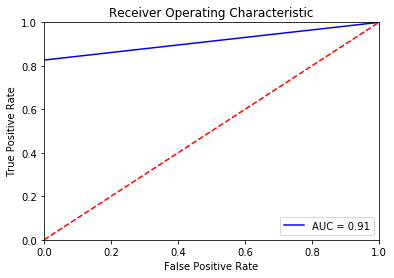

In [58]:
import matplotlib.pyplot as plt

fpr, tpr, threshold = metrics.roc_curve(y_true, y_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [54]:
# Grid Search for Algorithm Tuning
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
# prepare a range of alpha values to test
alphas = np.array([1, 0.1, 0.01, 0.001, 0.0001, 0])
# create and fit a ridge regression model, testing each alpha
model = MultinomialNB()
grid = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas), scoring=metrics.make_scorer(metrics.f1_score))
grid.fit(df2_train, df_train.is_negation)
print(grid)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_.alpha)

/Users/jozefg/.virtualenvs/neg/lib/python3.5/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -


/Users/jozefg/.virtualenvs/neg/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


/Users/jozefg/.virtualenvs/neg/lib/python3.5/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
/Users/jozefg/.virtualenvs/neg/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


/Users/jozefg/.virtualenvs/neg/lib/python3.5/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
/Users/jozefg/.virtualenvs/neg/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


GridSearchCV(cv=None, error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([  1.00000e+00,   1.00000e-01,   1.00000e-02,   1.00000e-03,
         1.00000e-04,   0.00000e+00])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(f1_score), verbose=0)
0.520956697522
0.001


In [ ]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')


df = pd.DataFrame({'true': y_true, 'predicted': y_pred})
df['token'] = df_test.token
print_full(df)

## Playground